In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from explainerdashboard import InlineExplainer, ExplainerDashboard, ClassifierExplainer
import random

In [2]:
class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.
    """
    
    def __init__(self, data):
        self.data = data.reset_index(drop=True).copy()
        #self.data = self.data.drop(columns=['Label'])

    def encode(self, target_column, sparse_n, threshold):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that high correlation
              higher that the threshold to the target label.
            - cat (string): The category label to compare to.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target columns.
        """


        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()
        ohe_list = []    
        attack_cat = self.data['attack_cat']
        # Go through each unique category in the target column.
        for c in categories:
            col_name = f'{target_column}_{c}'

            # Create the binary encoding column for the current category and target label
            corr_column = (self.data[target_column] == c).astype(int)
            correlation = corr_column.corr(attack_cat)

            # Check if absolute correlation is greater than threshold.
            if abs(correlation) > threshold:
                corr_column.name = col_name
                ohe_list.append(corr_column)
        print('Number of Encoded Features for', target_column)
        print(len(ohe_list))
        if ohe_list:
            # NOTE: This section can be expanded to include print outs but at the moment am focusing on the evaluations.
            ohe_df = pd.concat(ohe_list, axis=1)
            return ohe_df
        else:
            # This ommits errors (if really high thresholds are used).
            print("No correlations exceed the threshold.")
            return pd.DataFrame()

In [18]:
data = pd.read_csv('Cleaned_full_data.csv')
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
# Select a threat category.
category = 'DoS'
threshold = 0.1
data['attack_cat'] = (data['attack_cat'] == category).astype(int)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_22840\586737965.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
data2 = data[data['attack_cat']==1]
# Check total amount of different ports used for dos attacks. - Many features.
print(len(data2['dsport'].value_counts()))
print(len(data2['sport'].value_counts()))

205
3486


In [ ]:
# Encode specifically for DoS attacks. Set to 0.1 to have an output ready.
# NOTE: When using group by for DoS dsport has 205 values and sport has 3486 values.
encoder = CorrEncoder(data)
ohe1 = encoder.encode('dsport', 30, threshold)
ohe2 = encoder.encode('proto', 30, threshold)
ohe3 = encoder.encode('sport', 30, threshold)
ohe4 = encoder.encode('srcip', 30, threshold)
ohe5 = encoder.encode('dstip', 30, threshold)
ohe6 = encoder.encode('state', 30, threshold)
ohe7 = encoder.encode('service', 30, threshold)

Number of Encoded Features for dsport
1
Number of Encoded Features for proto
1
Number of Encoded Features for sport
1
Number of Encoded Features for srcip
3
Number of Encoded Features for dstip
3
Number of Encoded Features for state
1
Number of Encoded Features for service
0
No correlations exceed the threshold.


In [ ]:
print(data.head())
data = data.drop(columns=['dsport', 'proto', 'sport', 'srcip', 'dstip', 'state', 'service'])

In [43]:
encoded_features = pd.concat([ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)
print(len(encoded_features))
data = pd.concat([data, encoded_features], axis=1)

2540047


In [ ]:
data2 = data.copy()
downsample = 0.5
rs = 123
mask = (data2['label'].shift(-1) != 1) & (data2['label'].shift(1) != 1)
normal_rows = data2[(data2['attack_cat'] == 0) & mask]
percentage_to_remove = int(len(normal_rows) * downsample)
rows_to_remove = normal_rows.sample(n=percentage_to_remove, random_state=rs)
data2 = data2.drop(rows_to_remove.index)
print(f"Downsampled Rows: {len(rows_to_remove)}")

Downsampled Rows: 1081468


In [45]:
print(data.head())

        dur  sbytes  dbytes  sttl  dttl  sloss  dloss         sload  \
0  0.001055     132     164    31    29      0      0  500473.93750   
1  0.036133     528     304    31    29      0      0   87676.08594   
2  0.001119     146     178    31    29      0      0  521894.53130   
3  0.001209     132     164    31    29      0      0  436724.56250   
4  0.001169     146     178    31    29      0      0  499572.25000   

          dload  spkts  ...  dsport_0  proto_unas  sport_0  \
0  621800.93750      2  ...         0           0        0   
1   50480.17188      4  ...         0           0        0   
2  636282.37500      2  ...         0           0        0   
3  542597.18750      2  ...         0           0        0   
4  609067.56250      2  ...         0           0        0   

   srcip_175.45.176.1  srcip_175.45.176.0  srcip_175.45.176.2  \
0                   0                   0                   0   
1                   0                   0                   0   
2    

In [46]:
# Sample 100000 for simplicity.
#data_sampled = data.sample(n=100000, random_state=42)
# Drop labels for scaling.
features = data.drop(columns=['attack_cat', 'label'])
label = data['label']
attack_cat = data['attack_cat']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_data_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_data_df['attack_cat'] = attack_cat.reset_index(drop=True)
# Split 20% test.
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, label, test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])
# Check label distribution.
print(scaled_data_df['attack_cat'].value_counts())
# Run RandomForest with default settings.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


attack_cat
0    2523694
1      16353
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010

[[442928    903]
 [   919  63260]]


In [47]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: 0
Total samples: 504695
Correct predictions: 502880
Accuracy: 0.9964037686127265
Precision: 0.9851614493468079
Recall: 0.9850157728706624
F1-Score: 0.9850886057230178

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     60864

    accuracy                           1.00    504695
   macro avg       0.99      0.99      0.99    504695
weighted avg       1.00      1.00      1.00    504695

--------------------------------------------------
Evaluation for attack category: 1
Total samples: 3315
Correct predictions: 3308
Accuracy: 0.9978883861236802
Precision: 1.0
Recall: 0.9978883861236802
F1-Score: 0.9989430771553677

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      3315

    accuracy                 

In [71]:
# Sample 100000 for simplicity.
#data_sampled = data.sample(n=100000, random_state=42)
# Drop labels for scaling.
features = data2.drop(columns=['attack_cat', 'label'])
label = data2['label']
attack_cat = data2['attack_cat']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_data_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_data_df['attack_cat'] = attack_cat.reset_index(drop=True)
# Split 20% test.
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, label, test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])
# Check label distribution.
print(scaled_data_df['attack_cat'].value_counts())
# Run RandomForest with default settings.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

attack_cat
0    1442226
1      16353
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228053
           1       0.98      0.99      0.99     63663

    accuracy                           0.99    291716
   macro avg       0.99      0.99      0.99    291716
weighted avg       0.99      0.99      0.99    291716

[[227044   1009]
 [   464  63199]]


In [72]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: 0
Total samples: 288491
Correct predictions: 287020
Accuracy: 0.994901054105674
Precision: 0.9834549479380176
Recall: 0.9923558026407228
F1-Score: 0.987885326503216

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    228053
           1       0.98      0.99      0.99     60438

    accuracy                           0.99    288491
   macro avg       0.99      0.99      0.99    288491
weighted avg       0.99      0.99      0.99    288491

--------------------------------------------------
Evaluation for attack category: 1
Total samples: 3225
Correct predictions: 3223
Accuracy: 0.9993798449612403
Precision: 1.0
Recall: 0.9993798449612403
F1-Score: 0.9996898263027295

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      3225

    accuracy                   

In [73]:
# Get correct and incorrect predictions. Create DataFrames then drop the columns.
X_test['incorrect_predictions'] = X_test['predicted_label'] != X_test['true_label']
X_test['correct_predictions'] = X_test['predicted_label'] == X_test['true_label']
incorrect_predictions = X_test[X_test['incorrect_predictions'] == True]
correct_predictions = X_test[X_test['correct_predictions'] == True]
sdata1 = incorrect_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label', 'true_label'])
sdata2 = correct_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label', 'true_label'])
# Validate.
print("Incorrect Predictions (All):")
print(len(sdata1))
print("Correct Predictions (All):")
print(len(sdata2))


Incorrect Predictions (All):
1473
Correct Predictions (All):
290243


In [74]:
print(sdata2['attack_cat'].value_counts())

attack_cat
0    287020
1      3223
Name: count, dtype: int64


In [78]:
dos_correct = sdata2[sdata2['attack_cat'] == 1]
dos_incorrect = sdata1[sdata1['attack_cat'] == 1]
print(len(dos_correct))
print(len(dos_incorrect))
normal_correct = sdata2[sdata2['attack_cat'] == 0]
normal_incorrect = sdata1[sdata1['attack_cat'] == 0]
print(len(normal_correct))
print(len(normal_incorrect))

3223
2
287020
1471


In [77]:
dos_correct = dos_correct.drop(columns=['attack_cat'])
dos_incorrect = dos_incorrect.drop(columns=['attack_cat'])
normal_correct = normal_correct.drop(columns=['attack_cat'])
normal_incorrect = normal_incorrect.drop(columns=['attack_cat'])

In [79]:
dos_correct = dos_correct.sample(n=1000, random_state=42)

In [80]:
# Calculate shap for DoS rows.
# Incorrect Predictions.
explainer = shap.TreeExplainer(rf)
shap_values1 = explainer.shap_values(dos_incorrect)
# Verify shape.
print(shap_values1.shape)
print(dos_correct.shape)
# Correct Predictions.
explainer = shap.TreeExplainer(rf)
shap_values2 = explainer.shap_values(dos_correct)
# Verify shape.
print(shap_values2.shape)
print(dos_incorrect.shape)

(1000, 71, 2)
(1000, 71)
(2, 71, 2)
(2, 71)


Correct Predictions


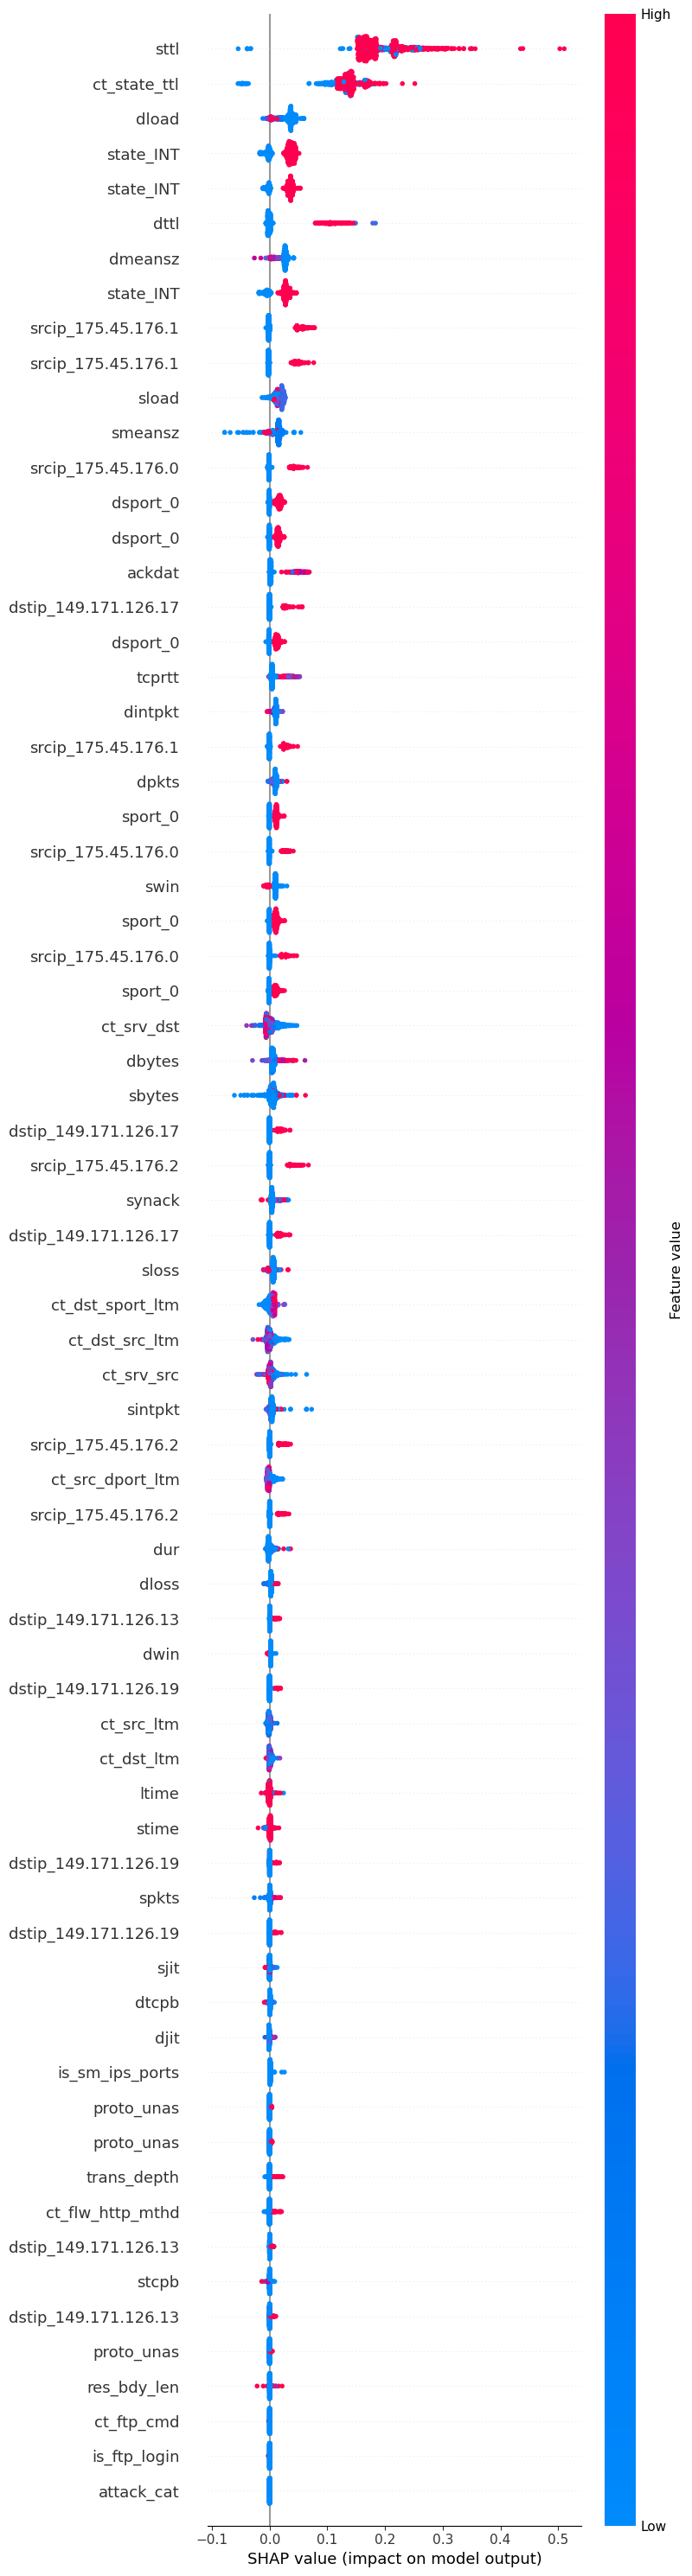

Incorrect Predictions


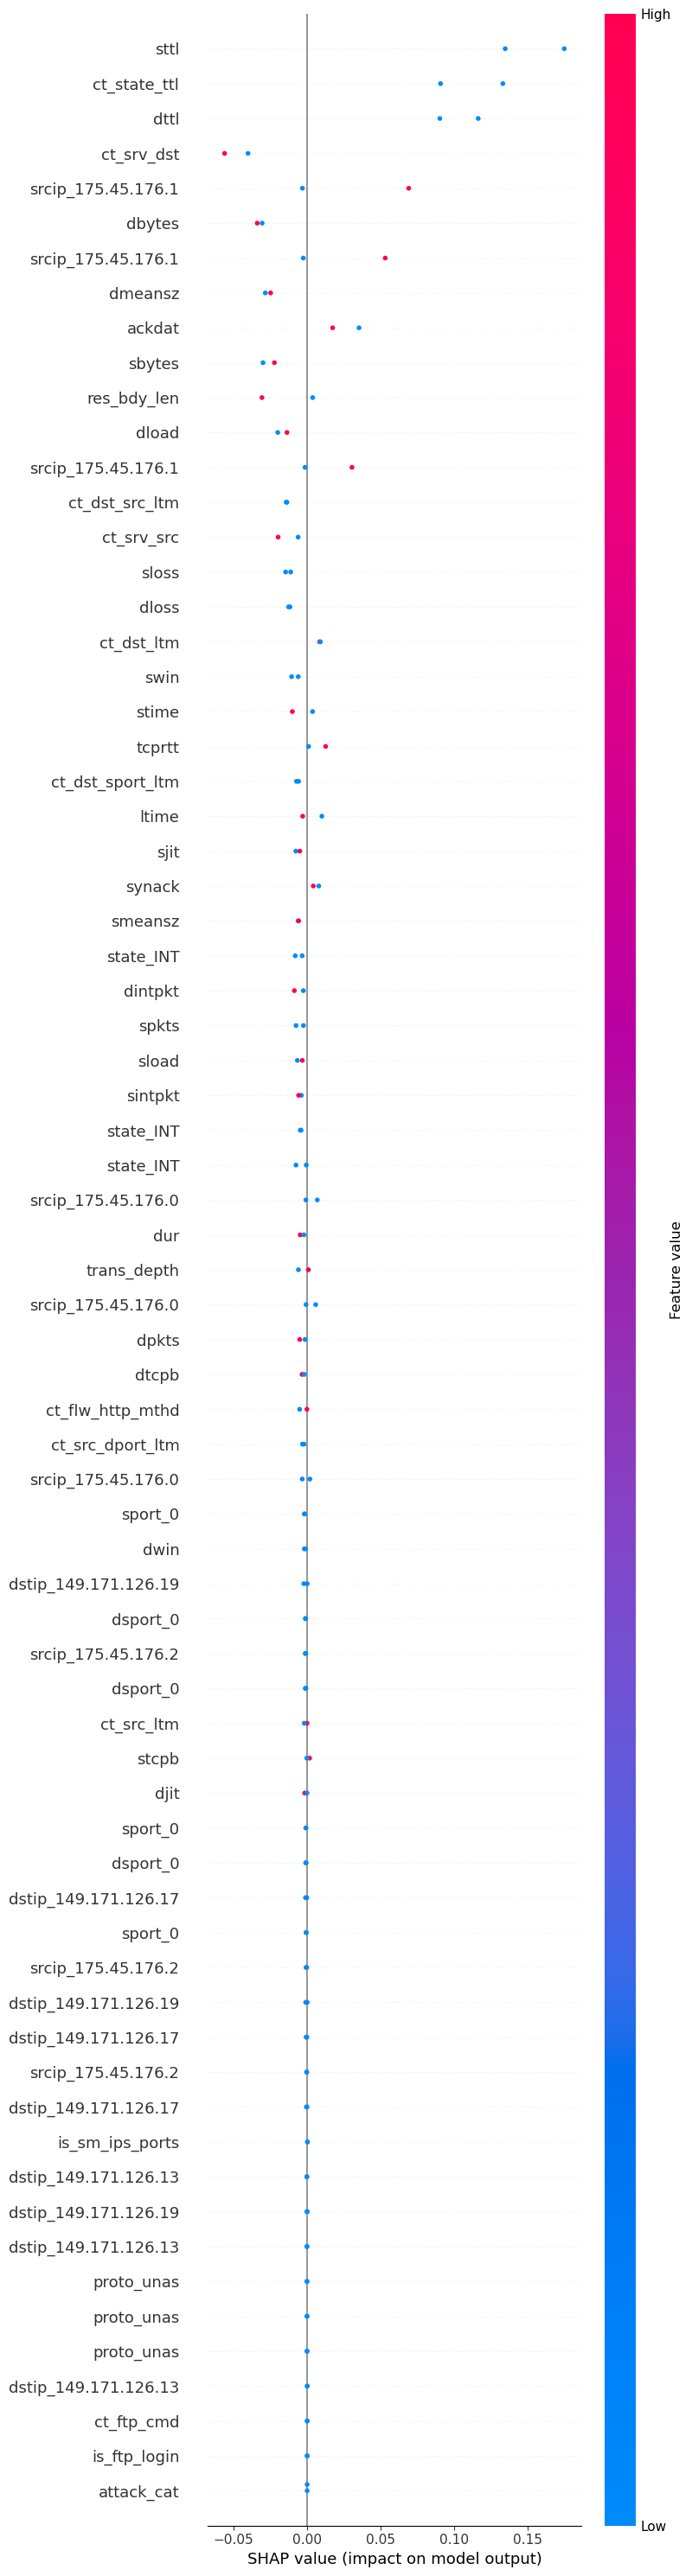

In [82]:
print('Correct Predictions')
shap.summary_plot(shap_values1[:, :, 1], dos_correct, max_display=len(dos_correct.columns), show=True)

print('Incorrect Predictions')
shap.summary_plot(shap_values2[:, :, 1], dos_incorrect, max_display=len(dos_incorrect.columns), show=True)